In [1]:
from itertools import repeat
from pathlib import Path
import pickle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from IPython.display import display
from sklearn.linear_model import LinearRegression
from tqdm.notebook import tqdm
import seaborn as sns

from gradient_coding import GradientCoding
from multiplexed_sgc import MultiplexedSGC
from selective_repeat_sgc import SelectiveRepeatSGC
from no_coding import NoCoding
from utils import get_durations, load_profile, slugify, cdf, \
    folder_params, DELAY_DIR, ridge_plot

models = {
    'GC': GradientCoding,
    'SRSGC': SelectiveRepeatSGC,
    'MSGC': MultiplexedSGC,
    'No Coding': NoCoding,
}

FIG_DIR = Path('/Users/reza/Library/CloudStorage/OneDrive-UniversityofToronto/Sequential Gradient Coding/ICLR-2023/paper figures')


In [2]:
# Plot themes

colors = {
    'GC': 'tab:blue',
    'SRSGC': 'tab:green',
    'MSGC': 'tab:orange',
    'No Coding': 'tab:red'
}

rc = {}

rc['axes.linewidth'] = 0.5
rc['axes.edgecolor'] = 'grey'
rc['xtick.color'] = 'black'
rc['ytick.color'] = 'black'
rc['axes.labelcolor'] = 'black'
rc['xtick.major.size'] = 4
rc['ytick.major.size'] = 4
rc['xtick.major.width'] = 0.5
rc['ytick.major.width'] = 0.5
rc['ytick.left'] = True
rc['xtick.bottom'] = True
rc['figure.dpi'] = 200
# rc["text.usetex"]= True
rc["font.family"]= "serif"
rc["font.sans-serif"]= "dejavusans"


sns.set_theme(style='darkgrid', context='paper', rc=rc)


# Lambda Straggler Pattern

In [16]:
folder = 'sam-gc-cnn_profile_est_desktop_long4_new'
invokes = 100
# folder = 'sam-gc-cnn_profile_est_desktop_long4_real_2'
# invokes = 500

workers = 256
batch = 4096
comp_type = 'no_forloop'

region = 'London'
# region = 'Canada'
load = 0.0
mu = 1

rounds = load_profile(workers, invokes, load, batch, comp_type, region, folder)
durs = get_durations(rounds).T

#NOTE:
# durs = np.random.permutation(durs)

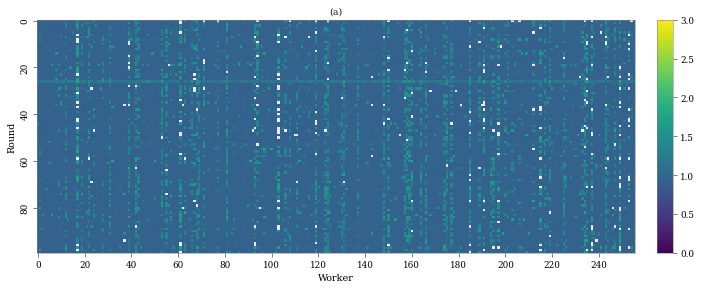

In [17]:
wait_time = durs.min(axis=0) * (1 + mu)

fig, axs = plt.subplots(1, 2, figsize=(10, 4),
                        gridspec_kw={"width_ratios":[1, 0.025]},
                        tight_layout=True)

# Heatmap
sns.heatmap(durs.T, mask=durs.T > wait_time[:, None], ax=axs[0], 
            yticklabels=20, xticklabels=20, cbar_ax=axs[1], cmap='viridis',
            vmin=0, vmax=3, square=True)

axs[0].set(ylabel='Round', xlabel='Worker', title='(a)')

for ax in axs.flat:
    ax.spines.right.set_visible(True)
    ax.spines.left.set_visible(True)
    ax.spines.top.set_visible(True)
    ax.spines.bottom.set_visible(True)

# fig.savefig(FIG_DIR / '1.pdf', dpi=1000)

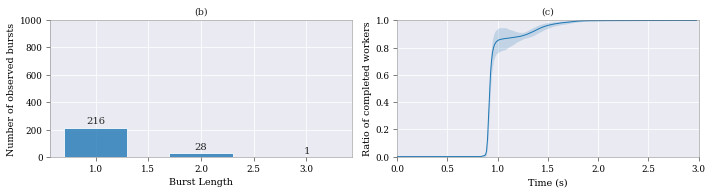

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(10, 2.8),
                        gridspec_kw={"width_ratios":[1, 1]},
                        tight_layout=True)

# Bursts
is_straggler = (durs > wait_time).astype(int)

# pad zero to begining and the end
is_straggler = np.concatenate([
    np.zeros((workers, 1)),
    is_straggler,
    np.zeros((workers, 1))], axis=1)

diff = np.diff(is_straggler, axis=1)
bursts = np.nonzero(diff == -1)[1] - np.nonzero(diff == 1)[1] 


axs[0].bar(*np.unique(bursts, return_counts=True),
           width=0.6, color='tab:blue', edgecolor='w', linewidth=1, alpha=0.8)

axs[0].bar_label(axs[0].containers[0], padding=2)
axs[0].set(ylim=(0, 1000), title='(b)',
           xlabel='Burst Length', ylabel='Number of observed bursts')
axs[0].grid(True)


bins = np.arange(0, 3, 0.01)
dur_cdf = np.array([cdf(dur, bins) for dur in durs.T])

# for d in dur_cdf:
    # axs[1].plot(bins[:-1], d, lw=0.12, c='b')

axs[1].plot(bins[:-1], dur_cdf.mean(axis=0), lw=1, c='tab:blue')
axs[1].fill_between(x=bins[:-1], 
                    y1=dur_cdf.mean(0) + dur_cdf.std(0), y2=dur_cdf.mean(0)-dur_cdf.std(0),
                    alpha=0.2, color='tab:blue', lw=0)

axs[1].set(xlabel='Time (s)', ylabel='Ratio of completed workers', title='(c)',
       xlim=(0, np.round(bins[-1])), ylim=(0-0.005,1+0.005))
axs[1].grid(True)


# fig.savefig(FIG_DIR / '2.pdf')


# 1. Probing Profile

In [36]:
# folder = 'sam-gc-cnn_profile_est_desktop_long4'
# folder = 'sam-gc-cnn_profile_est_desktop_long4_real'
folder = 'sam-gc-cnn_profile_est_desktop_long4_new'

workers, invokes, profile_loads, batch, comp_type, regions = folder_params(folder)

region = 'London'
# region = 'Canada'


print(f'{workers=}', f'{invokes=}', f'{profile_loads=}', f'{batch=}',
      f'{comp_type=}', f'{region=}', sep="\n")

workers=256
invokes=100
profile_loads=[0.0, 0.25, 0.5, 0.75, 1.0]
batch=4096
comp_type='no_forloop'
region='London'


In [20]:
# load all profiles

dur_list = []
for load in profile_loads:
    rounds = load_profile(workers, invokes, load, batch, comp_type, region, folder)
    durs = get_durations(rounds).T  
    #NOTE:
    # durs = np.random.permutation(durs)
    dur_list.append(durs)
    
dur_list = np.array(dur_list)
#NOTE:
# dur_list[1, :, 0] = dur_list[1, :, 20] + np.random.rand(workers)*0.1 

In [15]:
def dur2round(dur, rounds):
    for r, round in enumerate(rounds):
        round['round'] = r
        for w, worker in enumerate(round['results']):
            worker['finished'] = worker['started'] + dur[w, r]
    return rounds


folder_new = folder + '_new'

(DELAY_DIR / folder_new).mkdir(exist_ok=True)
for i, load in enumerate(profile_loads):
    fname = f"w{workers}-n{invokes}-l{slugify(load)}-b{batch}-c{slugify(comp_type)}-{region}.pkl"
    
    with open(DELAY_DIR / folder / fname, 'rb') as file:
        rounds = pickle.load(file)
        
    rounds = dur2round(dur_list[i], rounds)
    with open(DELAY_DIR / folder_new / fname, 'wb') as file:
        # pickle.dump(rounds, file)

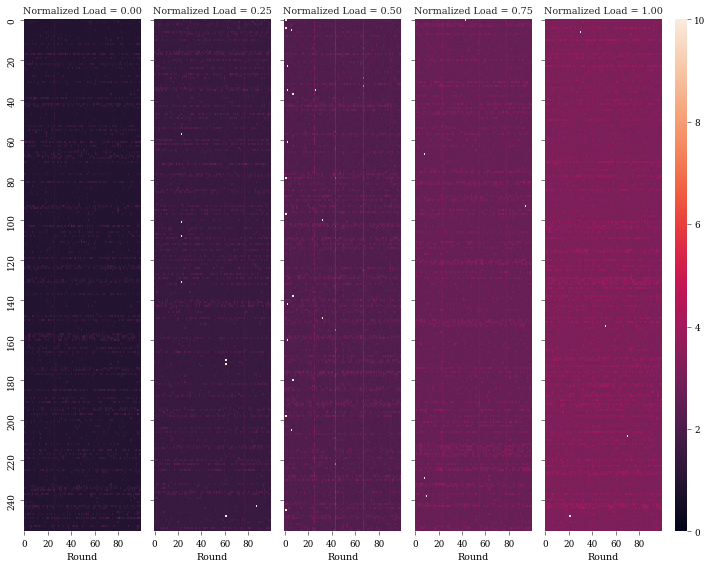

In [21]:
# analyze straggler pattern of each profile

fig, axs = plt.subplots(1, len(profile_loads) + 1, figsize=(10, 8), 
                        gridspec_kw={"width_ratios":[1, 1, 1, 1, 1, 0.1]},
                        tight_layout=True)

for i, (durs, load, ax) in enumerate(zip(dur_list, profile_loads, axs.flat)):
    
    
    sns.heatmap(durs, ax=ax, vmin=0, vmax=10, yticklabels=20, xticklabels=20, cbar_ax=axs[-1])
    ax.set_title(f'Normalized Load = {load:.2f}')
    ax.set_xlabel('Worker')
    ax.set_xlabel('Round')
    ax.tick_params(left=True, bottom=True)
    if i != 0:
        ax.set_yticklabels([])

In [22]:
# FIND BASE_COMP
    
lr = LinearRegression().fit(
    y = np.array(dur_list).reshape(-1,),
    X = np.repeat(profile_loads, dur_list[0].size).reshape(-1, 1)
) 
base_comp = lr.coef_[0]

print(f'{base_comp = :.4f}')

base_comp = 2.2621


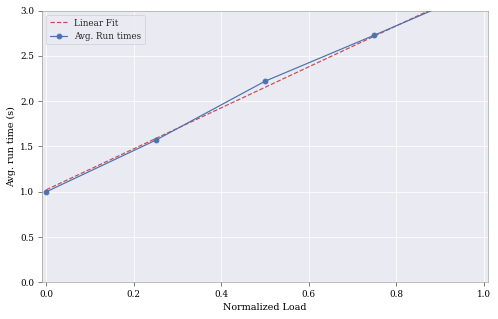

In [23]:
# Plot linear regression

fig, ax = plt.subplots(figsize=(8, 5))
ax.errorbar(x=profile_loads,
            y=[d.mean() for d in dur_list],
       #      yerr=[d.std() for d in dur_list],
            label='Avg. Run times', marker='o'
)

x = np.arange(0, 1, 0.1)
y = x * lr.coef_[0] + lr.intercept_
ax.plot(x, y, 'r--', label='Linear Fit')

ax.set(xlabel = 'Normalized Load',
       ylabel = 'Avg. run time (s)',
       xlim=(0-0.01, 1+0.01), ylim=(0, 3))
# ax.set_title(f'{base_comp=}')
ax.grid(True)
ax.legend()


# Ridge plot

# l = np.array([[l] * dur_list[0].size for l in profile_loads]).flatten()
# x = np.array(dur_list).flatten()
# sel = x < 10
# x = x[sel]
# l = l[sel]
# ridge_plot(x, l, bw_adjust=3, xlabel='completion time (s)');


# fig.savefig(FIG_DIR/'5.pdf', bbox_inches='tight')



# 2. Selecting Scheme Parameters 

In [24]:
#  LOAD BASE (REFERENCE) PROFILE

n_jobs = 80  # number of jobs to complete
base_load = 0.0
mu = 1.0

max_delay = invokes - n_jobs  # total number of rounds profiled - number of jobs to complete

rounds = load_profile(workers, invokes, base_load, batch, comp_type, region, folder)
base_delays = get_durations(rounds).T # (workers, rounds)

In [27]:
# RUN ALL PARAMS

def find_runtime(Model, params):
    load = Model.normalized_load(workers, *params)
    delays = base_delays + (load - base_load) * base_comp
    model = Model(workers, *params, n_jobs, mu, delays)
    model.run()
    durations = model.durations
    assert (durations >= 0).all()
    return durations.sum()


runtimes_df = []
for model_name, Model in models.items():
    params_combinations = list(Model.param_combinations(workers, n_jobs, max_delay))
    loads = [Model.normalized_load(workers, *params) for params in params_combinations]
    runtimes = [find_runtime(Model, params) for params in tqdm(params_combinations)]
    
    runtimes_df += zip(repeat(model_name), runtimes, loads, params_combinations)
    
runtimes_df = pd.DataFrame(runtimes_df, columns=['model_name', 'runtime', 'load', 'params'])
df = runtimes_df.loc[runtimes_df.groupby('model_name')['runtime'].idxmin()]
df = df.set_index('model_name')

df

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/70144 [00:00<?, ?it/s]

  0%|          | 0/25600 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

,runtime,load,params
model_name,,,
GC,146.019678,0.027344,"(6,)"
MSGC,143.753638,0.007102,"(1, 2, 9)"
No Coding,152.593047,0.003906,()
SRSGC,144.300829,0.015625,"(1, 2, 6)"


In [28]:
# save estimated runtimes
fname = f'mu{slugify(mu)}-base_load{slugify(base_load)}-njobs{n_jobs}-base_comp{slugify(base_comp)}-{region}'

fpath = (DELAY_DIR / folder / fname).with_suffix('.csv')
df.to_csv(fpath)    

fname += '_all'
fpath = (DELAY_DIR / folder / fname).with_suffix('.csv')
runtimes_df.to_csv(fpath)

In [28]:
# load estimated runtimes
import ast

fname = f'mu{slugify(mu)}-base_load{slugify(base_load)}-njobs{n_jobs}-base_comp{slugify(base_comp)}-{region}'

fpath = (DELAY_DIR / folder / fname).with_suffix('.csv')
df = pd.read_csv(fpath, index_col='model_name', converters={"params": ast.literal_eval})  
df = df.sort_values(by=['runtime'])

fname += '_all'
fpath = (DELAY_DIR / folder / fname).with_suffix('.csv')
runtimes_df = pd.read_csv(fpath, index_col=0, converters={"params": ast.literal_eval})

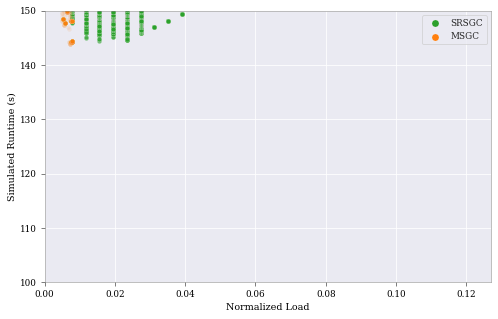

In [31]:
fig, ax = plt.subplots(figsize=(8, 5))

alpha = {
    'GC': 1,
    'SRSGC': 0.6,
    'MSGC': 0.1,
    'No Coding': 1,
}
size = {
    'GC': 65,
    'SRSGC': 20,
    'MSGC': 20,
    'No Coding': 50,
}

for model_name in models:
    if model_name in ['GC', 'No Coding']:
        continue
    
    model_time = runtimes_df[runtimes_df['model_name']==model_name]
    sns.scatterplot(data=model_time,
                    x="load", y="runtime",
                    linewidth=0, alpha=alpha[model_name], 
                    color=colors[model_name], s=size[model_name], label=model_name, lw=0.2)

ax.set_xlabel('Normalized Load')
ax.set_ylabel(f'Simulated Runtime (s)')
# ax.set_title(f'{workers=} {region=} {mu=} {n_jobs=} ')

ax.grid(True)

ax.set_ylim(100, 150)
ax.set_xlim(0, 0.127)

leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_sizes([50])

# fig.savefig(FIG_DIR/'6.png', dpi=600)

In [29]:
# best params
df = df.sort_values(by=['runtime'])
display(df)

,runtime,load,params
model_name,,,
MSGC,143.753638,0.007102,"(1, 2, 9)"
SRSGC,144.300829,0.015625,"(1, 2, 6)"
GC,146.019678,0.027344,"(6,)"
No Coding,152.593047,0.003906,()


(0.0, 83.95)

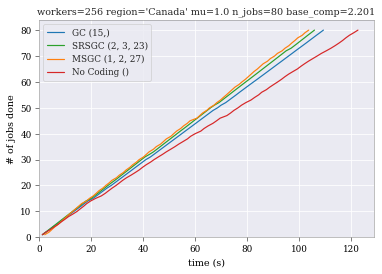

In [31]:
fig, ax = plt.subplots()
for model_name, Model in models.items():
    best_params = df.loc[model_name, 'params']
    load = df.loc[model_name, 'load']
    
    delays = base_delays + (load - base_load) * base_comp
    model = Model(workers, *best_params, n_jobs, mu, delays)
    model.run()
    durations = model.durations
    
    x = durations[durations>0].cumsum()
    x = x[-n_jobs:] 
    ax.plot(x, np.arange(n_jobs)+1, label=f'{model_name} {best_params}', c=colors[model_name])


ax.set_xlabel('time (s)')
# ax.set_ylabel('train acc')
ax.set_ylabel('# of jobs done')
ax.grid(True)
ax.set_title(f'{workers=} {region=} {mu=} {n_jobs=} {base_comp=:.3f}')
ax.legend();
ax.set_xlim(0)
ax.set_ylim(0)

In [84]:
# Real profile grid Search for parameter s of GC

s_range = [1, 10, 15, 20, 30, 40, 50, 60, 70, 80]
#NOTE:


# 3. Real Runtimes

In [40]:
folder_real = folder + '_real_2'
# invokes = 500
invokes = 400
mu = 1

In [51]:
# load all real profiles

dur_list = []
for model_name, load in zip(df.index, df['load']):
    rounds = load_profile(workers, invokes, load, batch, comp_type, region, folder_real)
    durs = get_durations(rounds).T
    
    #NOTE:
    # durs = np.random.permutation(durs)
    
    dur_list.append(durs)
dur_list = np.array(dur_list)


n_jobs = dur_list[0].shape[1] - max_delay  # number of jobs to complete

In [50]:
def dur2round(dur, rounds):
    for r, round in enumerate(rounds):
        round['round'] = r
        for w, worker in enumerate(round['results']):
            worker['finished'] = worker['started'] + dur[w, r]
    return rounds


# (DELAY_DIR / folder_new).mkdir(exist_ok=True)
for i, load in enumerate(df['load']):
    fname = f"w{workers}-n{invokes}-l{slugify(load)}-b{batch}-c{slugify(comp_type)}-{region}.pkl"
    
    with open(DELAY_DIR / folder_real / fname, 'rb') as file:
        rounds = pickle.load(file)
        
    rounds = dur2round(dur_list[i], rounds)
    with open(DELAY_DIR / folder_real / fname, 'wb') as file:
        pickle.dump(rounds, file)

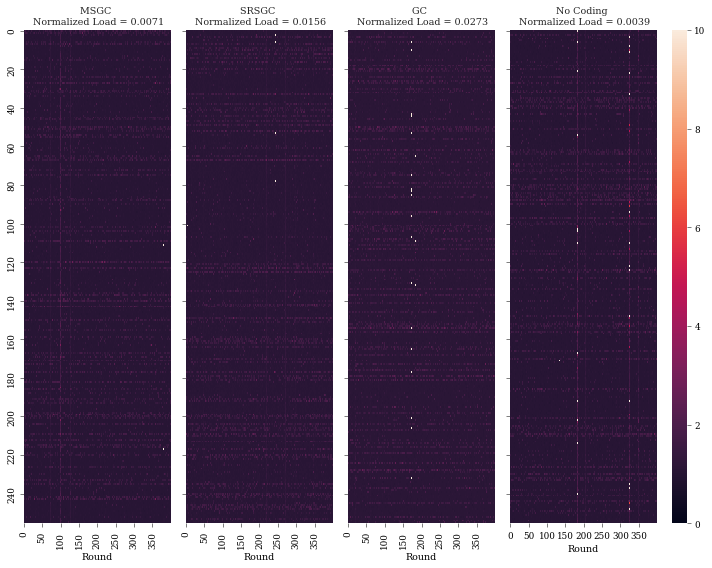

In [52]:
fig, axs = plt.subplots(1, len(dur_list) + 1, figsize=(10, 8), 
                        gridspec_kw={"width_ratios":[1, 1, 1, 1, 0.1]},
                        tight_layout=True)

for i, (durs, load, ax, model_name) in enumerate(zip(dur_list, df['load'], axs.flat, df.index)):
    
    sns.heatmap(durs, ax=ax, vmin=0, vmax=10, yticklabels=20, xticklabels=50, cbar_ax=axs[-1])
    ax.set_title(f'{model_name} \n Normalized Load = {load:.4f}')
    ax.set_xlabel('Worker')
    ax.set_xlabel('Round')
    ax.tick_params(left=True, bottom=True)
    if i != 0:
        ax.set_yticklabels([])

In [54]:
#%% MULTIPLE RUNS

np.random.seed(10)    

num_tries = 10
# num_splits = 20

runtimes = {}
for model_name, durs, load in zip(df.index, dur_list, df['load']):
    
    _runtimes = {'total': [], 'rounds': [], 'wait_outs': []}
    
    for n in range(num_tries):            
        rounds = load_profile(workers, invokes, load, batch, comp_type, region, folder_real, suffix=n)
        durs = get_durations(rounds).T

        best_params = df.loc[model_name, 'params']

        model = models[model_name](workers, *best_params, n_jobs, mu, durs)
        model.run()
        durations = model.durations
        
        _x = durations[durations>0].cumsum()[-n_jobs:]
        _runtimes['rounds'].append(_x)
        _runtimes['total'].append(durations.sum())
        _runtimes['wait_outs'].append(model.num_waits)
        
        
    runtimes[model_name] = _runtimes

In [53]:
#%% MULTIPLE RUNS

np.random.seed(10)    

num_tries = 10
num_splits = 20

runtimes = {}
for model_name, durs, load in zip(df.index, dur_list, df['load']):
    
    _runtimes = {'total': [], 'rounds': [], 'wait_outs': []}
    
    for n in range(num_tries):            
        durs_split = np.array_split(durs, num_splits, axis=1)
        durs_split = [durs_split[i] for i in np.random.permutation(num_splits)]
        durs_shuffled = np.concatenate(durs_split, axis=1)
        durs_shuffled += (np.random.uniform(size=durs.shape) > 0.9999) * 20
                
        fname = f"w{workers}-n{invokes}-l{slugify(load)}-b{batch}-c{slugify(comp_type)}-{region}.pkl"
        fname2 = f"w{workers}-n{invokes}-l{slugify(load)}-b{batch}-c{slugify(comp_type)}-{region}-{n}.pkl"

        with open(DELAY_DIR / folder_real / fname, 'rb') as file:
            rounds = pickle.load(file)

        rounds = dur2round(durs_shuffled, rounds)
        with open(DELAY_DIR / folder_real / fname2, 'wb') as file:
            pickle.dump(rounds, file)

        best_params = df.loc[model_name, 'params']

        model = models[model_name](workers, *best_params, n_jobs, mu, durs_shuffled)
        model.run()
        durations = model.durations
        
        _x = durations[durations>0].cumsum()[-n_jobs:]
        _runtimes['rounds'].append(_x)
        _runtimes['total'].append(durations.sum())
        _runtimes['wait_outs'].append(model.num_waits)
        

        
    runtimes[model_name] = _runtimes

In [55]:
df = df[['load', 'params']]
for model_name in df.index:
    runtime_mean = np.mean(runtimes[model_name]['total'])
    runtime_std = np.std(runtimes[model_name]['total'])

    df.loc[model_name, 'runtime'] = f'{runtime_mean:.2f} ± {runtime_std:.2f} (s)'
    df.loc[model_name, 'wait_outs'] = np.mean(runtimes[model_name]['wait_outs'])
    
    
display(df)

,load,params,runtime,wait_outs
model_name,,,,
MSGC,0.007102,"(1, 2, 9)",798.41 ± 26.05 (s),23.4
SRSGC,0.015625,"(1, 2, 6)",883.46 ± 7.57 (s),17.2
GC,0.027344,"(6,)",970.92 ± 26.08 (s),16.6
No Coding,0.003906,(),1190.17 ± 104.20 (s),380.0


[Text(0.5, 0, 'Time (s)'),
 Text(0, 0.5, 'Number of jobs done'),
 (0.0, 1400.0),
 (0.0, 490.0),
 Text(0.5, 1.0, '(a)')]

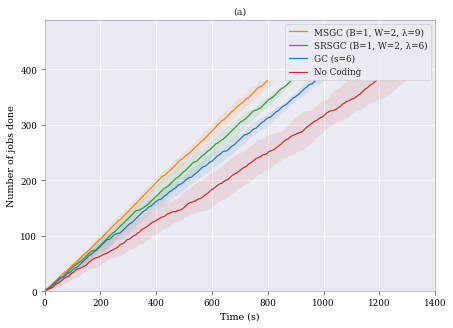

In [56]:
fig, ax = plt.subplots(figsize=(7, 5))

for model_name in df.index:
    p = df.loc[model_name, 'params']
    
    if np.isnan(p).all():
        p = tuple()
        
    if len(p) == 3:
        B, W, l = p
        p = f'(B={B}, W={W}, λ={l})'
    elif len(p) == 1:
        p = f'(s={p[0]})'
    elif len(p) == 0:
        p = ''
        
    times = np.array(runtimes[model_name]['rounds'])
    

    ax.plot(times.mean(axis=0), np.arange(n_jobs)+1, 
            label=f'{model_name} {p}', c=colors[model_name])
    ax.fill_betweenx(y=np.arange(n_jobs)+1, 
                     x1=times.mean(0) + times.std(0), x2=times.mean(0) - times.std(0),
                     lw=0.2, alpha=0.1, color=colors[model_name])
    # for time in times:
    #     ax.plot(time, np.arange(n_jobs)+1, c=colors[model_name], lw=0.1, ls='-.')

ax.grid(True)
ax.legend()
ax.set(xlabel='Time (s)', ylabel= 'Number of jobs done',
       xlim=(0, 1400), ylim=(0, 490), title='(a)')
# ax.set_rasterized(True)

# fig.savefig(FIG_DIR / '3.pdf')


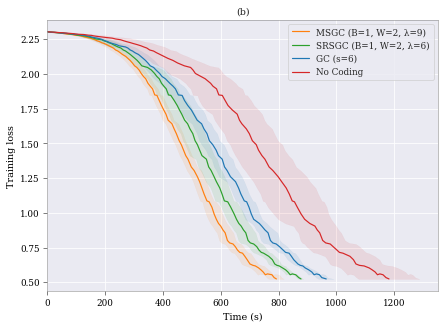

In [57]:
with open('./train_acc.pkl', 'rb') as f:
    train_acc, train_loss = pickle.load(f)

fig, ax = plt.subplots(figsize=(7, 5))
for model_name in df.index:
    p = df.loc[model_name, 'params']

    if np.isnan(p).all():
        p = tuple()

    
    if len(p) == 3:
        B, W, l = p
        p = f'(B={B}, W={W}, λ={l})'
    elif len(p) == 1:
        p = f'(s={p[0]})'
    elif len(p) == 0:
        p = ''
        
    times = np.array(runtimes[model_name]['rounds'])
    times = times[:, ::4]
    
    
    # print(times.shape)
    ax.plot(times.mean(0), train_loss[:times.shape[1]],
            label=f'{model_name} {p}', c=colors[model_name])
    
    ax.fill_betweenx(y=train_loss[:times.shape[1]], 
                     x1=times.mean(0) + times.std(0), x2=times.mean(0) - times.std(0),
                     lw=0.2, alpha=0.1, color=colors[model_name])
    
    # for time in times:
    #     ax.plot(time, train_acc[:len(time)], alpha=1, c=colors[model_name], lw=0.1, ls='-.')

ax.grid(True)
ax.legend()
ax.set(xlabel='Time (s)', ylabel= 'Training loss',
       xlim=(0, None), title='(b)');

fig.savefig(FIG_DIR / '4.pdf')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


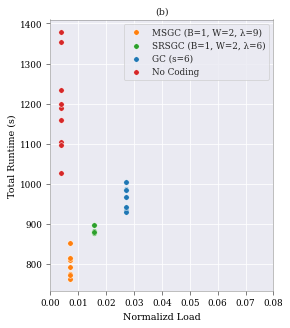

In [58]:
fig, ax = plt.subplots(figsize=(4, 5))

for model_name, load, p in zip(df.index, df['load'], df['params']):
    r = runtimes[model_name]['total']
    if len(p) == 3:
        B, W, l = p
        p = f'(B={B}, W={W}, λ={l})'
    elif len(p) == 1:
        p = f'(s={p[0]})'
    elif len(p) == 0:
        p = ''
    ax.scatter([load]*len(r), r, c=colors[model_name],
               edgecolors='w', linewidths=0.5, s=30, 
               label=f'{model_name} {p}')

    # sns.violinplot(data=pd.DataFrame(runtimes) , inner="points", orient="v")
ax.legend()
ax.grid(True)
ax.set(ylabel='Total Runtime (s)', xlabel='Normalizd Load',
       xlim=(0, 0.08), title='(b)')

fig.savefig(FIG_DIR / '4.eps', bbox_inches='tight')